In [ ]:
# default_exp callback.core

# Callback core

> Miscellaneous callbacks for timeseriesAI.

In [ ]:
#export 
from tsai.imports import *
from tsai.utils import *
from tsai.data.transforms import *
from tsai.models.layers import *
from fastai.callback.all import *

In [ ]:
#export
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

## Events: 

A callback can implement actions on the following events:
* before_fit: called before doing anything, ideal for initial setup.
* before_epoch: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
* before_train: called at the beginning of the training part of an epoch.
* before_batch: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
* after_pred: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
* after_loss: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
* before_backward: called after the loss has been computed, but only in training mode (i.e. when the backward pass will be used)
* after_backward: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
* after_step: called after the step and before the gradients are zeroed.
* after_batch: called at the end of a batch, for any clean-up before the next one.
* after_train: called at the end of the training phase of an epoch.
* before_validate: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
* after_validate: called at the end of the validation part of an epoch.
* after_epoch: called at the end of an epoch, for any clean-up before the next one.
* after_fit: called at the end of training, for final clean-up.

## Learner attributes:

When writing a callback, the following attributes of Learner are available:

* **model**: the model used for training/validation
* **data**: the underlying DataLoaders
* **loss_func**: the loss function used
* **opt**: the optimizer used to udpate the model parameters
* **opt_func**: the function used to create the optimizer
* **cbs**: the list containing all Callbacks
* **dl**: current DataLoader used for iteration
* **x/xb**: last input drawn from self.dl (potentially modified by callbacks). xb is always a tuple (potentially with one element) and x is detuplified. You can only assign to xb.
* **y/yb**: last target drawn from self.dl (potentially modified by callbacks). yb is always a tuple (potentially with one element) and y is detuplified. You can only assign to yb.
* **pred**: last predictions from self.model (potentially modified by callbacks)
* **loss**: last computed loss (potentially modified by callbacks)
* **n_epoch**: the number of epochs in this training
* **n_iter**: the number of iterations in the current self.dl
* **epoch**: the current epoch index (from 0 to n_epoch-1)
* **iter**: the current iteration index in self.dl (from 0 to n_iter-1)

The following attributes are added by TrainEvalCallback and should be available unless you went out of your way to remove that callback:
* **train_iter**: the number of training iterations done since the beginning of this training
* **pct_train**: from 0. to 1., the percentage of training iterations completed
* **training**: flag to indicate if we're in training mode or not

The following attribute is added by Recorder and should be available unless you went out of your way to remove that callback:
* **smooth_loss**: an exponentially-averaged version of the training loss

## Gambler's loss: noisy labels

In [ ]:
#export
class GamblersCallback(Callback):
    "A callback to use metrics with gambler's loss"
    def after_loss(self): self.learn.pred = self.learn.pred[..., :-1]

In [ ]:
from tsai.data.all import *
from tsai.models.InceptionTime import *
from tsai.models.layers import *
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
loss_func = gambler_loss()
learn = Learner(dls, InceptionTime(dls.vars, dls.c + 1), loss_func=loss_func, cbs=GamblersCallback, metrics=[accuracy])
learn.fit_one_cycle(1)

Dataset: NATOPS
X      : (360, 24, 51)
y      : (360,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179], [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 20

epoch,train_loss,valid_loss,accuracy,time
0,1.743125,1.570689,0.288889,00:05


## Transform scheduler

In [ ]:
# export
class TransformScheduler(Callback):
    "A callback to schedule batch transforms during training based on a function (sched_lin, sched_exp, sched_cos (default), etc)"
    def __init__(self, schedule_func:callable, show_plot:bool=False): 
        self.schedule_func,self.show_plot = schedule_func,show_plot
        self.mult = []

    def before_fit(self):
        for pct in np.linspace(0, 1, len(self.dls.train) * self.n_epoch): self.mult.append(self.schedule_func(pct))
        # get initial magnitude values and update initial value
        self.mag = []
        self.mag_tfms = []
        for t in self.dls.after_batch: 
            if hasattr(t, 'magnitude'):
                self.mag.append(t.magnitude)
                t.magnitude *= self.mult[0]
                self.mag_tfms.append(t)

    def after_batch(self):
        if self.training and len(self.mag_tfms)>0 and self.train_iter < len(self.mult):
            # set values for next batch
            for t,m in zip(self.mag_tfms, self.mag): 
                t.magnitude = m * self.mult[self.train_iter]
                
    def after_fit(self):
        if self.show_plot and self.mult != [] and len(self.mag_tfms)>0: 
            print()
            plt.plot(self.mult)
            plt.title('Scheduled tfms')
            plt.show()
            print()
            self.show_plot = False
        # set values to initial values
        for t,m in zip(self.mag_tfms, self.mag): t.magnitude = m
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.schedule_func})'

In [ ]:
TransformScheduler(SchedCos(1, 0))

TransformScheduler(<fastai.callback.schedule._Annealer object at 0x7f9a70d8b490>)

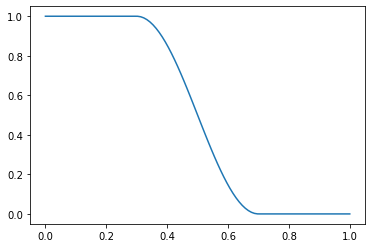

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3, 0.4, 0.3], [SchedLin(1.,1.), SchedCos(1.,0.), SchedLin(0.,.0), ])
plt.plot(p, [f(o) for o in p]);

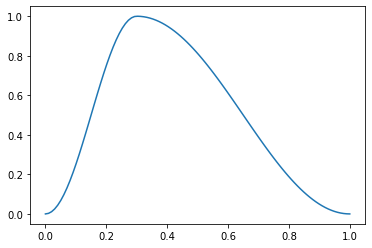

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3, 0.7], [SchedCos(0.,1.), SchedCos(1.,0.)])
plt.plot(p, [f(o) for o in p]);

## ShowGraphCallback

In [ ]:
#export
class ShowGraphCallback2(Callback):
    "(Modified) Update a graph of training and validation loss"
    run_after,run_valid=ProgressCallback,False

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not(self.run): return
        self.nb_batches = []
        assert hasattr(self.learn, 'progress')

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_min = min((min(rec.losses), min(val_losses)))
        y_max = max((max(rec.losses), max(val_losses)))
        margin = (y_max - y_min) * .05
        y_bounds = (y_min - margin, y_max + margin)
        self.progress.mbar.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.transforms.ipynb.
Converted 003b_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.FCN.ipynb.
Converted 103b_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 105_models.RNNPlus.ipynb.
Converted 106_models.XceptionTime.ipynb.
Converted 106b_models.XceptionTimePlus.ipynb.
Converted 107_models.RNN_FCN.ipynb.
Converted 107b_models.RNN_FCNPlus.ipynb.
Co